# Analyzing the Titanic dataset

Here we will perform an analysis of the [Kaggle Titanic dataset](https://www.kaggle.com/c/titanic/data) concerned with the passengers involved in the [RMS Titanic](https://en.wikipedia.org/wiki/RMS_Titanic) iceberg collision disaster April 14th to 15th, 1912.

First we load up the dataset and take a look at the raw data in order to get an understanding about the kind of data we're dealing with. Knowing the kind and shape of the available data will allow us to come up with questions we can ask about the dataset, as well as strategies to prepare the data for the analysis.

In [1]:
import pandas as pd
titanic = pd.read_csv('titanic-data.csv')
titanic = titanic.set_index('PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The dataset consists of about 900 entries.

In [2]:
len(titanic), len(titanic.dropna(how='any'))

(891, 183)

This is less than half of the actual number of passengers of the Titanic (which is said to be over `2200`). Naturally, with a that big amount of the data missing, this dataset is likely to only give a rather limited approximation. Only 83 rows contain complete information.

The columns are encoded as follows:
* `PassengerId` is a unique ID for each passenger,
* `Survived` is a binary value encoding if the passenger survived (`1`) or died in the accident (`0`),
* `Pclass` represents the ticket class in range `1..3`, with `1` representing 1st class, etc.,
* `Name` gives the name of the passenger,
* `Sex` the sex,
* `Age` the age, with the value being fractional if less than `1.0` or estimated,
* `SibSp` gives the number of siblings or spouses aboard the ship,
* `Parch` gives the number of parents or children aboard the ship,
* `Ticket` represents the ticket number,
* `Fare` the passenger fare,
* `Cabin` the cabin number, and
* `Embarked` the port of embarkation, with `C` representing Cherbourg, `Q` for Queenstown and `S` for Southhampton.

For `SibSp`, the definition of _sibling_ is brother, sister, stepbrother or stepsister, where _spouse_ means husband or wife, with mistresses and fiancés not being represented. 
For `Parch`, _parent_ means mother or father, where _child_ means daughter, son, stepdaughter or stepson. Children travelling only with a Nanny will thus have a value of `0` in this column.

The value of `Pclass` can furthermore be taken as a proxy for the socio-economic status of the passenger, with a 1st class ticket (`1`) encoding upper class, whereas a 3rd class ticket (`3`) represents lower class status.

## Questions to be asked

The obvious question for a ship accident is if [Women and children first](https://en.wikipedia.org/wiki/Women_and_children_first) indeed holds for the passenger of the Titanic. If so, we would expect to see a higher number of women and children having survived the accident than men. Additionally we might be interested in seeing if a higher social-economic status (or ticket class, for that matter), correlates with survivorship - and lastly, if there is a skew in the classes of children and women towards ticket class.
The initial overview shows to cases of women names containing `Miss` or `Mrs.`, indicating marriage status. Maybe unmarried women were more likely to survive, because they were younger? Were they? Generally, does age correlate with survivorship?

A somewhat silly, but similar question is if the Titanic's captain, [Edward Smith](https://en.wikipedia.org/wiki/Edward_Smith_&#40;sea_captain&#41;), did sink with his ship, which can be easily determined if his name is represented in the list of "passengers". We do, however, already know from reports he was in the vicinity of, but not on the bridge five minutes before the ship disappered beneath the ocean and that his body was never discovered.

The cabin number might correlate with survivorship, depending on where in the Titanic the cabin was located. This information might be even more helpful when correlated with knowledge about ongoing events aboard the ship and their locations. These questions, however, cannot be answered from this dataset alone. Since the accident happened at 23:40h ship time (UTC -3:27h), the assumption that people were in their cabins might hold, thus we might be able to correlate deck names or cabin numbers with survivorship.
However, even if people made it to the lifeboats, survivorship should still be dependent on the time it took for rescue to arrive given the circumstances.

The ticket number appears unlikely to be of use since it does not seem to be uniform. However, [this thread](https://www.kaggle.com/c/titanic/discussion/11127) suggests that identical ticket numbers can be used to determine shared cabin usage (for when no cabin information is present) or joint ticket usage.

We might be able to find other relationships between survivorship and available variables by examining statistics conditioned on the recorded survivorship.

## Cabin allocations

According to [Ecyclopedia Titanica](https://www.encyclopedia-titanica.org/cabins.html), the cabin allocations
were obtained from an incomplete first class passenger list recovered with the body of one of the stewards, Herbert Cave. The first letter in the `Cabin` field encodes the deck, where `A` represents the topmost and `G` the bottommost deck. The complete deckplans can be found [here](https://www.encyclopedia-titanica.org/titanic-deckplans/).


![](images/Titanic_cutaway_diagram.png)



We know that the Titanic rammed the iceberg near the bow, which resulted in the ship sinking "heads first". From the deck plan it appears that most 1st class areas were assigned to the front half of the ship, which could imply that passengers assigned to cabins in these areas have a lower survivorship recorded.


# Assessing data quality

We first validate if the column data is actually in the format we expect.

### Survirorship

There are indeed two distinct values for the `Survivor` column, so we change this column to be boolean.

In [3]:
titanic['Survived'].unique()

array([0, 1])

In [4]:
titanic['Survived'] = titanic['Survived'].astype(bool).astype('category')
titanic['Survived'].unique()

[False, True]
Categories (2, object): [False, True]

### Ticket class

Similarly the ticket class contains only the expected values `1..3`. We turn it into a categorical variable as well.

In [5]:
titanic['Pclass'].unique()

array([3, 1, 2])

In [6]:
import numpy as np
titanic['Pclass'] = titanic['Pclass'].astype(np.uint8).astype('category')
titanic['Pclass'].unique()

[3, 1, 2]
Categories (3, uint64): [3, 1, 2]

### Sex

The passenger's sex does not show unexpected values and is converted to a categorical value.

In [7]:
titanic['Sex'].unique()

array(['male', 'female'], dtype=object)

In [8]:
import numpy as np
titanic['Sex'] = titanic['Sex'].astype(str).astype('category')
titanic['Sex'].unique()

[male, female]
Categories (2, object): [male, female]

### Passenger name

Out of curiosity, we check if the number of distinct passenger names is equal to the length of the list. That appears to be the case, so no (obvious) duplications exist in the dataset.

In [9]:
len(titanic['Name'].unique()) - len(titanic['Name'])

0

Let's check if captain Edward Smith appears in the dataset:

In [10]:
titanic.loc[titanic['Name'].apply(lambda name: 'Smith' in name)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
175,False,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C
261,False,3,"Smith, Mr. Thomas",male,NaN,0,0,384461,7.7500,NaN,Q
285,False,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S
347,True,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.0000,NaN,S


It turns out he doesn't (unless there is a typo in the name). Likewise, Herbert Cave, from whom the cabin assignment list was retrieved, does not appear in the dataset:

In [11]:
titanic.loc[titanic['Name'].apply(lambda name: 'Cave' in name)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
742,False,1,"Cavendish, Mr. Tyrell William",male,36.0,1,0,19877,78.85,C46,S


This makes clear the dataset indeed only appears to represent _passengers_ aboard the Titanic, not every person.

Let's make sure every name field has exactly one comma in it by counting how many names cannot be split in exactly two groups:

In [12]:
len(titanic.loc[titanic['Name'].apply(lambda name: len(name.split(',')) != 2)])

0

Since we know for sure we can split each name into exactly two values and the family name appears to be the first piece, let's split them:

In [13]:
titanic['LastName'] = titanic['Name'].apply(lambda name: name.split(',')[0].strip())
titanic['FirstName'] = titanic['Name'].apply(lambda name: name.split(',')[1].strip())
del titanic['Name']

titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,FirstName
PassengerId,,,,,,,,,,,,
1,False,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris
2,True,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
3,True,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss. Laina
4,True,1,female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs. Jacques Heath (Lily May Peel)
5,False,3,male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr. William Henry


While we're at it, let's also look at the _Mrs._, _Miss_ and _Ms._ indictors:

In [14]:
titanic[titanic['Sex'] == 'female']['FirstName'].apply(lambda name: name.split()[0]).value_counts()

Miss.    182
Mrs.     125
Mlle.      2
Dr.        1
Lady.      1
the        1
Mme.       1
Ms.        1
Name: FirstName, dtype: int64

It appears there are the representations [_Miss._](https://en.wikipedia.org/wiki/Miss) and [_Mlle._](https://en.wikipedia.org/wiki/Mademoiselle_&#40;title&#41;) for unmarried women, as well as [_Mrs._](https://en.wikipedia.org/wiki/Mrs.) and _Mme._ for married women. _Ms._ is no clear indicator and the cases `Lady.`, `the` and `Dr.` would require to be investigated further. Since each of these only occurs once, we decide to simply drop these values.

In [15]:
def woman_marriage_status(name):
    if 'Miss.' in name or 'Mlle.' in name:
        return False
    if 'Mrs.' in name or 'Mme.' in name:
        return True
    return float('NaN')

titanic['MarriedWoman'] = titanic['FirstName'].apply(woman_marriage_status)
titanic[['Sex', 'FirstName', 'MarriedWoman']].head()

,Sex,FirstName,MarriedWoman
PassengerId,,,
1,male,Mr. Owen Harris,NaN
2,female,Mrs. John Bradley (Florence Briggs Thayer),True
3,female,Miss. Laina,False
4,female,Mrs. Jacques Heath (Lily May Peel),True
5,male,Mr. William Henry,NaN


### Age

All of the values in the list appear to be convertible to `float`, which also includes `NaN` values.

In [16]:
import math
def is_valid_float(value, allow_nan=False):
  try:
    f = float(value)
    return allow_nan or not math.isnan(f)
  except ValueError:
    return False

In [17]:
titanic['Age'].apply(lambda x: is_valid_float(x, allow_nan=True)).unique()

array([ True], dtype=bool)

There are `714` passengers who do have a recorded age and `177` passengers for which no age information is present.

In [18]:
titanic['Age'].apply(lambda x: is_valid_float(x, allow_nan=False)).value_counts()

True     714
False    177
Name: Age, dtype: int64

In [19]:
titanic['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

### Siblings and spouses

No unexpected data is in the `SibSp` column.

In [20]:
titanic['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

### Parents and children

Same goes for the `Parch` column.

In [21]:
titanic['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6])

### Ticket

Let's have a look at the structure of the `Ticket` column:

In [22]:
titanic['Ticket'].head()

PassengerId
1           A/5 21171
2            PC 17599
3    STON/O2. 3101282
4              113803
5              373450
Name: Ticket, dtype: object

It appears that we might be able to split the ticket number into an optional prefix and a numerical value. Let's see if this assumption holds:

In [23]:
titanic['Ticket'].apply(lambda x: len(x.split())).value_counts()

1    665
2    213
3     13
Name: Ticket, dtype: int64

Apparently there are 13 ticket numbers that have more than two fields. Let's look them up:

In [24]:
show = ['Sex', 'Ticket', 'Fare', 'Embarked', 'LastName', 'FirstName']

splits = titanic['Ticket'].apply(lambda x: len(x.split()))
titanic[splits == 3].sort_values('Ticket')[show]

,Sex,Ticket,Fare,Embarked,LastName,FirstName
PassengerId,,,,,,
474,female,SC/AH Basle 541,13.7917,C,Jerwan,Mrs. Amin S (Marie Marthe Thuillard)
415,male,STON/O 2. 3101269,7.9250,S,Sundman,Mr. Johan Julian
591,male,STON/O 2. 3101273,7.1250,S,Rintamaki,Mr. Matti
434,male,STON/O 2. 3101274,7.1250,S,Kallio,Mr. Nikolai Erland
244,male,STON/O 2. 3101275,7.1250,S,Maenpaa,Mr. Matti Alexanteri
174,male,STON/O 2. 3101280,7.9250,S,Sivola,Mr. Antti Wilhelm
665,male,STON/O 2. 3101285,7.9250,S,Lindqvist,Mr. Eino William
580,male,STON/O 2. 3101286,7.9250,S,Jussila,Mr. Eiriik
745,male,STON/O 2. 3101288,7.9250,S,Stranden,Mr. Juho


According to [this report](https://www.encyclopedia-titanica.org/titanic-survivor/marie-marthe-jerwan.html), Mrs. Marie Jerwan had ticket number `541`. Similarly, [Mr. Eiriik Jussilas](https://www.encyclopedia-titanica.org/titanic-survivor/eiriik-jussila.html) ticket number is reported as `3101286`. We can thus assume that only the last split encodes the actual ticket number, with everything else being a prefix.

In [25]:
titanic['TicketNumber'] = titanic['Ticket'].apply(lambda x: x.split()[-1].strip())
titanic['TicketPrefix'] = titanic['Ticket'].apply(lambda x: ' '.join(x.split()[:-1]).strip()).astype('category')
del titanic['Ticket']

A check on the extracted ticket numbers shows that not all values are indeed numerical:

In [26]:
def is_valid_int(x):
    try:
        int(x)
        return True
    except ValueError:
        return False

titanic['TicketNumber'].apply(is_valid_int).value_counts()

True     887
False      4
Name: TicketNumber, dtype: int64

Let's bring them up:

In [27]:
titanic[~titanic['TicketNumber'].apply(is_valid_int)]['TicketNumber']

PassengerId
180    LINE
272    LINE
303    LINE
598    LINE
Name: TicketNumber, dtype: object

In all these cases, the ticket is registered as `LINE`. We can find from [this report](https://www.encyclopedia-titanica.org/titanic-survivor/william-henry-tornquist.html) that the ticket numbers of Lionel Törnquist, Alfred Johnson and William Johnson is actually `370160`. Lionel Leonard's real name was [Andrew John Shannon](https://www.encyclopedia-titanica.org/titanic-victim/lionel-leonard.html) and he too was travelling on the same ticket number, `370160`.

We will manually fix these values:

In [28]:
titanic['TicketNumber'] = titanic['TicketNumber'].apply(lambda x: 370160 if x == 'LINE' else x)

len(titanic[~titanic['TicketNumber'].apply(is_valid_int)])

0

We can now set the ticket number to be numerical.

In [29]:
titanic['TicketNumber'] = titanic['TicketNumber'].astype(int)

Finally, a quick evaluation of the ticket prefixes shows that the majority of the ticket numbers is prefixless, whereas some prefixes seem to occur more than once (e.g. `C.A.`, `CA.`, `CA` and `C.A./SOTON`).

In [30]:
titanic['TicketPrefix'].value_counts()

               665
PC              60
C.A.            27
STON/O 2.       12
A/5             10
W./C.            9
SOTON/O.Q.       8
CA.              8
SOTON/OQ         7
A/5.             7
STON/O2.         6
CA               6
SC/PARIS         5
S.O.C.           5
F.C.C.           5
C                5
SC/Paris         4
PP               3
A/4.             3
A/4              3
S.O./P.P.        3
A.5.             2
P/PP             2
A./5.            2
WE/P             2
SC/AH            2
SOTON/O2         2
S.C./PARIS       2
S.O.P.           1
F.C.             1
S.P.             1
S.W./PP          1
C.A./SOTON       1
SC               1
W/C              1
A4.              1
A/S              1
SC/AH Basle      1
SCO/W            1
SO/C             1
Fa               1
SW/PP            1
W.E.P.           1
S.C./A.4.        1
Name: TicketPrefix, dtype: int64

### Fare price

The fare price field is uniform.

In [31]:
titanic['Fare'].apply(lambda x: is_valid_float(x, allow_nan=False)).unique()

array([ True], dtype=bool)

### Cabin numbers

The cabin numbers column is not uniform. Apart from missing values (represented as `NaN`), some fields contain more than one entry, such as `'B57 B59 B63 B66'`, `'C23 C25 C27'` or `'F E69'`.

In [32]:
titanic['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24',

We will first determine the entries with cabin numbers both existing and in the expected format.

In [33]:
import re
cabin_re = re.compile('^[A-G][0-9]{1,3}$')

valid_cabins = titanic['Cabin'].apply(lambda c: isinstance(c, str) and cabin_re.match(c) is not None)
titanic[valid_cabins]['Cabin'].head()

PassengerId
2      C85
4     C123
7      E46
11      G6
12    C103
Name: Cabin, dtype: object

Next we determine entries with cabin numbers set, but deviating from the expected format. These entries seem to correlate to ticket numbers and last name of the passengers. In order to show the relation, we sort the cabin column by name.

In [34]:
titanic[~valid_cabins].dropna(subset=['Cabin']).sort_values('Cabin')['Cabin']

PassengerId
873        B51 B53 B55
680        B51 B53 B55
743    B57 B59 B63 B66
312    B57 B59 B63 B66
119            B58 B60
300            B58 B60
790            B82 B84
764            B96 B98
436            B96 B98
803            B96 B98
391            B96 B98
499            C22 C26
298            C22 C26
306            C22 C26
439        C23 C25 C27
28         C23 C25 C27
89         C23 C25 C27
342        C23 C25 C27
701            C62 C64
328                  D
474                  D
293                  D
98             D10 D12
129              F E69
700              F G63
716              F G73
76               F G73
340                  T
Name: Cabin, dtype: object

Looking these cabins up on the [Deckplan of the B Deck](https://www.encyclopedia-titanica.org/titanic-deckplans/b-deck.html) it becomes apparent that most of these cabins are colocated and connected through doors.

Here's the plan for the cabins **B51** (sitting room), **B53** and **B55** (starboard):

![](images/cabin_b555351.png)

And here's the plan for cabins **B58** and **B60** (port):

![](images/cabin_b5860.png)

The deck plans also make it apparent that **even** cabin numbers are port side ("left"), while **odd** cabin numbers are starboard side ("right"). Since the Titanic rammed the iceberg starboard, this might be interesting to look at.

The cabin `T` occupied by [Stephen Weart Blackwell](https://www.encyclopedia-titanica.org/titanic-victim/stephen-weart-blackwell.html) is situated on the boat deck, next to the starboard lifeboats.

![](images/cabin_t.png)

The cabins `F E69`, `F G63` and `F G73` correspond to the cabins `69, 63 and 73` of the `E` and `G` sections of deck `F`, respectively. The [Cabin Allocation](https://www.encyclopedia-titanica.org/cabins.html) list indicates these values might be wrong.

![](images/cabin_feg696373.png)

This results in the following cases for cabin allocations:

* Many passengers were assigned to a cabin (e.g. passenger `76` and `716`),
* many cabins were assigned to a passenger in general, and
* many cabins were assigned to many passengers of different name (e.g. passengers `873` and `680`).

Cabin names either follow the schema Deck, Number (e.g. cabin `B51`), Deck, Section and Number (`F G73`), Cabin letter (e.g. `T` for passenger `340`) or just a deck in general, if no information is present (e.g. `D` for passenger `328`). Cabin `T` appears to be the only recorded special case for known, single-letter cabin identifiers.

In all cases of multiple cabin allocations, the cabins are on the same deck. Thus, a single deck identifier can be used per passenger. They are also next to each other, except for the case of passenger `743` and `312` (the Ryersons).

Interestingly, for this case there are only two young women assigned to four cabins, where the sibling/spouse and parent/child indicator both suggest there should be more persons.

In [35]:
titanic.loc[titanic['LastName'].apply(lambda name: 'Ryerson' in name)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix
PassengerId,,,,,,,,,,,,,,
312,True,1,female,18.0,2,2,262.375,B57 B59 B63 B66,C,Ryerson,Miss. Emily Borie,False,17608,PC
743,True,1,female,21.0,2,2,262.375,B57 B59 B63 B66,C,Ryerson,"Miss. Susan Parker ""Suzette""",False,17608,PC


There are also no other persons assigned to any of these cabins.

In [36]:
titanic.loc[titanic['Cabin'].apply(lambda cabin: not isinstance(cabin, float) and 
                                   ('B57' in cabin or 'B59' in cabin or 
                                    'B63' in cabin or 'B66' in cabin))]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix
PassengerId,,,,,,,,,,,,,,
312,True,1,female,18.0,2,2,262.375,B57 B59 B63 B66,C,Ryerson,Miss. Emily Borie,False,17608,PC
743,True,1,female,21.0,2,2,262.375,B57 B59 B63 B66,C,Ryerson,"Miss. Susan Parker ""Suzette""",False,17608,PC


The [Cabin Assignments](https://www.encyclopedia-titanica.org/cabins.html) list suggests there were indeed more passengers that did not appear on the Cave List.

We will now split these information into separate columns encoding the deck of the cabin, the number of cabins assigned to the passenger, as well as the proportion of assigned cabins starboard.

In [37]:
def get_deck(cabin):
    if isinstance(cabin, float):
        assert math.isnan(cabin)
        return float('NaN')
    d = cabin[0]
    return 'Boat' if d == 'T' else d

def get_cabins(cabin):
    if isinstance(cabin, float):
        assert math.isnan(cabin)
        return None
    cabins = cabin.split()
    return [cabin] if cabins[0] == 'F' else cabins

def get_num_cabins(cabin):
    cabins = get_cabins(cabin)
    return float('NaN') if cabins is None else len(cabins)

def get_is_starboard(cabin):
    cabins = get_cabins(cabin)
    if cabins is None:
        return cabin
    # Edge case: For the cabins marked 'D' only the deck is known.
    if cabins == ['D']:
        return float('NaN')
    # From the deck plan we know cabin 'T' is starboard.
    if cabins == ['T']:
        return True
    # Looking at all the ending digits of all cabins, 
    # determine if they are odd, then take the mean.
    return np.array([int(c[-1]) % 2 for c in cabins]).mean()

titanic['CabinDeck'] = titanic['Cabin'].apply(get_deck).astype('category')
titanic['NumCabins'] = titanic['Cabin'].apply(get_num_cabins)
titanic['CabinsStarboard'] = titanic['Cabin'].apply(get_is_starboard)

In [38]:
titanic.sort_values('NumCabins', ascending=False)[['Cabin', 'NumCabins', 'CabinDeck', 'CabinsStarboard']].head(n=10)

,Cabin,NumCabins,CabinDeck,CabinsStarboard
PassengerId,,,,
743,B57 B59 B63 B66,4.0,B,0.75
312,B57 B59 B63 B66,4.0,B,0.75
680,B51 B53 B55,3.0,B,1
28,C23 C25 C27,3.0,C,1
342,C23 C25 C27,3.0,C,1
89,C23 C25 C27,3.0,C,1
439,C23 C25 C27,3.0,C,1
873,B51 B53 B55,3.0,B,1
499,C22 C26,2.0,C,0


The edge case of `F G73` shows only one cabin in the `NumCabins` column, as expected. 

In [39]:
titanic.loc[76]

Survived                       False
Pclass                             3
Sex                             male
Age                               25
SibSp                              0
Parch                              0
Fare                            7.65
Cabin                          F G73
Embarked                           S
LastName                        Moen
FirstName          Mr. Sigurd Hansen
MarriedWoman                     NaN
TicketNumber                  348123
TicketPrefix                        
CabinDeck                          F
NumCabins                          1
CabinsStarboard                    1
Name: 76, dtype: object

### Embarkation port

The port of embarkation column contains only the expected values `S`, `C` and `Q`, as well as some empty fields. It is changed to a categorical value.

In [40]:
titanic['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [41]:
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [42]:
titanic['Embarked'] = titanic['Embarked'].astype('category')
titanic['Embarked'].unique()

[S, C, Q, NaN]
Categories (3, object): [S, C, Q]

# Data visualization

With the data prepared, we can now look into visualizing the data. 

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Let's first look at the distribution of male and female passengers aboard the Titanic.

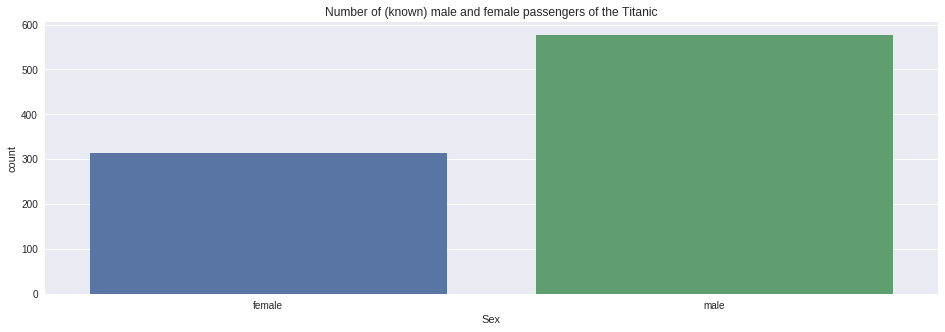

In [44]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.countplot(x='Sex', data=titanic)
plt.title('Number of (known) male and female passengers of the Titanic');

We can see that about twice as many men aboard the Titanic than women.

To get a quick overview about the survival rate, here's the distribution of survivors across all ages, sexes and ticket classes. From the plot, it appears that only about one third of the passengers survived the disaster at all.

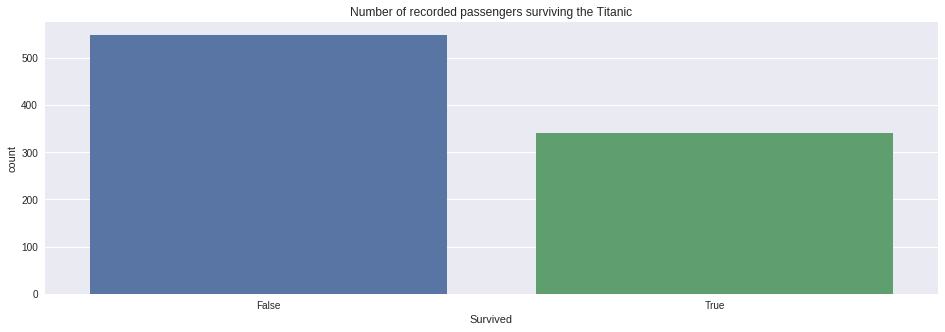

In [45]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.countplot(x='Survived', data=titanic)
plt.title('Number of recorded passengers surviving the Titanic');

## Women and children first

So, **Women and children first**? Let's have a look:

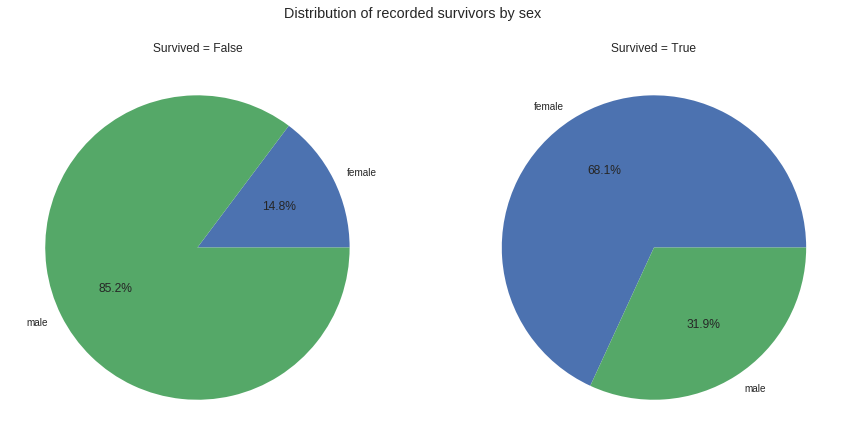

In [46]:
is_survivor = titanic['Survived'] == True
sums_s = titanic[is_survivor].Survived.groupby(titanic[is_survivor].Sex).count()
sums_n = titanic[~is_survivor].Survived.groupby(titanic[~is_survivor].Sex).count()

f, axs = plt.subplots(1, 2, sharex=True, figsize=(15, 7))
f.suptitle('Distribution of recorded survivors by sex');

axs[0].pie(sums_n, labels=sums_n.index, autopct='%1.1f%%')
axs[0].set_aspect('equal')
axs[0].set_title('Survived = False')

axs[1].pie(sums_s, labels=sums_s.index, autopct='%1.1f%%')
axs[1].set_aspect('equal')
axs[1].set_title('Survived = True');


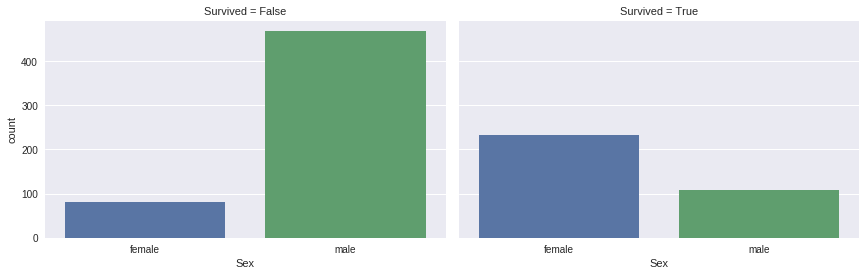

In [47]:
sns.factorplot(x='Sex', col='Survived', data=titanic, kind='count', size=4, aspect=1.5);

Clearly, more women survived the Titanic disaster than men did, and vastly more men died that night. While only about `38%` of the passengers survived, `74%` of the female passengers did, compared to only about `19%` of the men:

In [48]:
is_survivor = titanic['Survived'] == True
is_female = titanic['Sex'] == 'female'
is_male = ~is_female

def ratio(a, b):
    return len(titanic[a]) / len(titanic[b])

survivorship_ratio        = len(titanic[is_survivor]) / len(titanic)
female_survivorship_ratio = ratio(is_female & is_survivor, is_female)
male_survivorship_ratio   = ratio(is_male & is_survivor, is_male)

print('Survivors:        {:.3f}'.format(survivorship_ratio))
print('Female survivors: {:.3f}'.format(female_survivorship_ratio))
print('Male survivors:   {:.3f}'.format(male_survivorship_ratio))

Survivors:        0.384
Female survivors: 0.742
Male survivors:   0.189


Out of the survivors, about `68%` were female and `32%` male.

In [49]:
survivors_female = ratio(is_female & is_survivor, is_survivor)
survivors_male = ratio(~is_female & is_survivor, is_survivor)

print('Female survivors: {:.3f}'.format(survivors_female))
print('Male survivors:   {:.3f}'.format(survivors_male))

Female survivors: 0.681
Male survivors:   0.319


That does, of course, not imply that women and children did indeed leave the Titanic first and survived because of that. That said, what can we see specifically about the **Children** of the Titanic?

Looking at the age column, it appears that about `20%` of the entries (`177/891` values) do not have an age registered.

In [50]:
no_age = titanic['Age'].isnull().sum()
no_age, no_age / len(titanic)

(177, 0.19865319865319866)

When looking at a sample of the entries sorted by parent/child relations, it appears that some of these entries indeed are children, as we can guess by the titles in the given first names (_Miss_, _Master_). [Thomas Henry Sage](https://www.encyclopedia-titanica.org/titanic-victim/thomas-henry-sage.html) (entry 160), for example, was indeed five years old. [Catherine Helen Johnston](https://www.encyclopedia-titanica.org/titanic-victim/catherine-nellie-johnston.html) (entry 889, reported here as _Carrie_, but listed as _Nellie_ in the Encyclopedia), in turn, was of age seven.

In [51]:
titanic[titanic['Age'].isnull()].sort_values('Parch', ascending=False).head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix,CabinDeck,NumCabins,CabinsStarboard
PassengerId,,,,,,,,,,,,,,,,,
889,False,3,female,NaN,1,2,23.4500,NaN,S,Johnston,"Miss. Catherine Helen ""Carrie""",False,6607,W./C.,NaN,NaN,NaN
847,False,3,male,NaN,8,2,69.5500,NaN,S,Sage,Mr. Douglas Bullen,NaN,2343,CA.,NaN,NaN,NaN
534,True,3,female,NaN,0,2,22.3583,NaN,C,Peter,Mrs. Catherine (Catherine Rizk),True,2668,,NaN,NaN,NaN
141,False,3,female,NaN,0,2,15.2458,NaN,C,Boulos,Mrs. Joseph (Sultana),True,2678,,NaN,NaN,NaN
160,False,3,male,NaN,8,2,69.5500,NaN,S,Sage,Master. Thomas Henry,NaN,2343,CA.,NaN,NaN,NaN


Since for her `2` parents are registered (and/or childs, if we ignore that we already know for a fact her real age), we might be able to correlate her with her relatives by last name or ticket number, however it turns out that at least one entry appears to be missing and that for Mr. [Andrew Johnston](https://www.encyclopedia-titanica.org/titanic-victim/andrew-emslie-johnston.html) no age is given as well.

In [52]:
titanic[titanic['LastName'] == 'Johnston']

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix,CabinDeck,NumCabins,CabinsStarboard
PassengerId,,,,,,,,,,,,,,,,,
784,False,3,male,NaN,1,2,23.45,NaN,S,Johnston,Mr. Andrew G,NaN,6607,W./C.,NaN,NaN,NaN
889,False,3,female,NaN,1,2,23.45,NaN,S,Johnston,"Miss. Catherine Helen ""Carrie""",False,6607,W./C.,NaN,NaN,NaN


In [53]:
titanic[titanic['TicketNumber'] == 6607]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix,CabinDeck,NumCabins,CabinsStarboard
PassengerId,,,,,,,,,,,,,,,,,
784,False,3,male,NaN,1,2,23.45,NaN,S,Johnston,Mr. Andrew G,NaN,6607,W./C.,NaN,NaN,NaN
889,False,3,female,NaN,1,2,23.45,NaN,S,Johnston,"Miss. Catherine Helen ""Carrie""",False,6607,W./C.,NaN,NaN,NaN


While we might be able to impute or assume some of the actual values (see e.g. [here](https://measuringu.com/handle-missing-data/)) by cross-checking entries, for the rest of the age analyses we will simply discard rows for which no age is given.

When we look at the age distribution of the survivors compared to the non-survivors, we can observe a clear skew towards the younger ages.

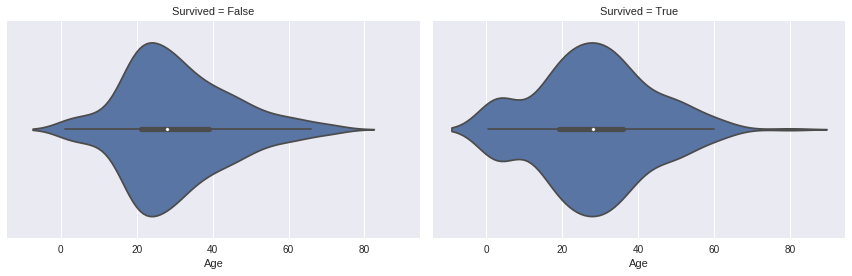

In [54]:
sns.factorplot(x='Age', col='Survived', data=titanic, kind='violin', size=4, aspect=1.5);

There are two cases of `14` and `15` year old girls that are married, namely [Adāl Naṣr Allāh](https://www.encyclopedia-titanica.org/titanic-survivor/adele-nasser.html) and [Selini Yazbeck](https://www.encyclopedia-titanica.org/titanic-survivor/selini-celiney-yazbeck.html).

In [55]:
titanic[(titanic['Age'] <= 15) & (titanic['MarriedWoman'] == True)][['LastName', 'FirstName', 'Age', 'Sex']]

,LastName,FirstName,Age,Sex
PassengerId,,,,
10,Nasser,Mrs. Nicholas (Adele Achem),14.0,female
831,Yasbeck,Mrs. Antoni (Selini Alexander),15.0,female


While not considered adult nowadays, for the rest of the analysis, we will consider children to be younger than `14` years.

Looking at the statistics of passengers in that group, we find that 42 children survived the event, with the children's age averaging around 4.3 years (the median age being 4 years).

In [56]:
childhood_threshold = 14
is_child = titanic['Age'] < childhood_threshold

titanic[is_survivor & is_child]['Age'].describe()

count    42.000000
mean      4.313571
std       3.528576
min       0.420000
25%       1.000000
50%       4.000000
75%       5.750000
max      13.000000
Name: Age, dtype: float64

So what is the proportion of children surviving the Titanic (conditioned on their sex) compared to that of adults?

In [57]:
child_survivors = is_survivor & is_child
child_survivorship_ratio        = ratio(child_survivors, is_child)
child_female_survivorship_ratio = ratio(is_female & child_survivors, is_female & is_child)
child_male_survivorship_ratio   = ratio(is_male & child_survivors, is_male & is_child)

print('Child survivors:        {:.3f}'.format(child_survivorship_ratio))
print('Female child survivors: {:.3f}'.format(child_female_survivorship_ratio))
print('Male child survivors:   {:.3f}'.format(child_male_survivorship_ratio))

Child survivors:        0.592
Female child survivors: 0.618
Male child survivors:   0.568


In [58]:
is_adult = ~is_child
adult_survivors = is_survivor & is_adult
adult_survivorship_ratio        = ratio(adult_survivors, is_adult)
adult_female_survivorship_ratio = ratio(is_female & adult_survivors, is_female & is_adult)
adult_male_survivorship_ratio   = ratio(is_male & adult_survivors, is_male & is_adult)

print('Adult survivors:        {:.3f}'.format(adult_survivorship_ratio))
print('Female adult survivors: {:.3f}'.format(adult_female_survivorship_ratio))
print('Male adult survivors:   {:.3f}'.format(adult_male_survivorship_ratio))

Adult survivors:        0.366
Female adult survivors: 0.757
Male adult survivors:   0.163


According to this, `59%` of the children survived, whereas only `36%` of the adults did. Within the group of children, `62%` of the girls survived compared to `57%` of the boys. The numbers are very close, so it's unlikely that looking at different sexes here is meaningful. Among the adults, `76%` of the women survived, but only `16%` of the men. 

Clearly, **Women and children first** _would_ explain what we see here, but of course, we cannot deduce that such an order was given from the data.

Here are the distributions presented visually.

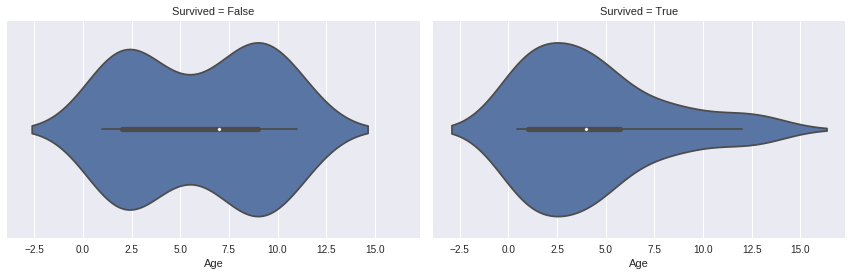

In [59]:
sns.factorplot(x='Age', col='Survived', data=titanic[is_child], kind='violin', size=4, aspect=1.5);

The distribution of children that did not survive is multimodal. The plot suggests that while some of the younger children (around age `2.5`) did not survive, also many children around the age of `10` did not make it to or survive the Lifeboats.

There are six children in the age group of `9` to `13` that did survive ...

In [60]:
columns = ['Sex', 'LastName', 'FirstName', 'SibSp', 'Parch', 'Cabin']
titanic[(titanic['Age'] > 8) & (titanic['Age'] < 14) & is_survivor].sort_values('Age', ascending=False)[columns]

,Sex,LastName,FirstName,SibSp,Parch,Cabin
PassengerId,,,,,,
447,female,Mellinger,Miss. Madeleine Violet,0,1,NaN
781,female,Ayoub,Miss. Banoura,0,0,NaN
126,male,Nicola-Yarred,Master. Elias,1,0,NaN
803,male,Carter,Master. William Thornton II,1,2,B96 B98
166,male,Goldsmith,"Master. Frank John William ""Frankie""",0,2,NaN
490,male,Coutts,"Master. Eden Leslie ""Neville""",1,1,NaN


... but `11` children that didn't. There are no cabin information for any of them.

In [61]:
titanic[(titanic['Age'] > 8) & (titanic['Age'] < 14) & (~is_survivor)].sort_values('Age', ascending=False)[columns]

,Sex,LastName,FirstName,SibSp,Parch,Cabin
PassengerId,,,,,,
60,male,Goodwin,Master. William Frederick,5,2,NaN
543,female,Andersson,Miss. Sigrid Elisabeth,4,2,NaN
732,male,Hassan,Mr. Houssein G N,0,0,NaN
420,female,Van Impe,Miss. Catharina,0,2,NaN
820,male,Skoog,Master. Karl Thorsten,3,2,NaN
148,female,Ford,"Miss. Robina Maggie ""Ruby""",2,2,NaN
183,male,Asplund,Master. Clarence Gustaf Hugo,4,2,NaN
481,male,Goodwin,Master. Harold Victor,5,2,NaN
542,female,Andersson,Miss. Ingeborg Constanzia,4,2,NaN


Interestingly there's not much of a difference between the sexes in the group of all children that did not survive, except that girls tended to be slightly older.

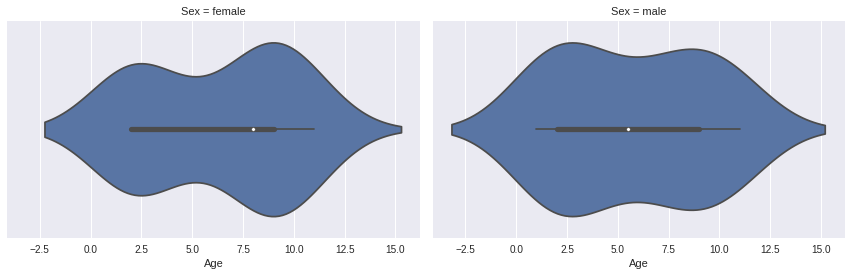

In [62]:
sns.factorplot(x='Age', col='Sex', data=titanic[~is_survivor & is_child], kind='violin', size=4, aspect=1.5);

Overall, when we look at the number of children wo did not survive, we find that there are `29` of them. With a sample size this small (and only `79` children to begin with), the effect of more of the older children not surviving might not be significant.

In [63]:
titanic[~is_survivor & is_child]['Age'].describe()

count    29.00000
mean      6.00000
std       3.55568
min       1.00000
25%       2.00000
50%       7.00000
75%       9.00000
max      11.00000
Name: Age, dtype: float64

In [64]:
print('Number of children aboard the Titanic: {}'.format(len(titanic[is_child])))

Number of children aboard the Titanic: 71


## Influence of the Ticket class

So what influence did the ticket class have on the survival? Let's look at sex (along the rows), survivorship (along the columns) and ticket class (the separate series) and relate it to the age of the passenger.

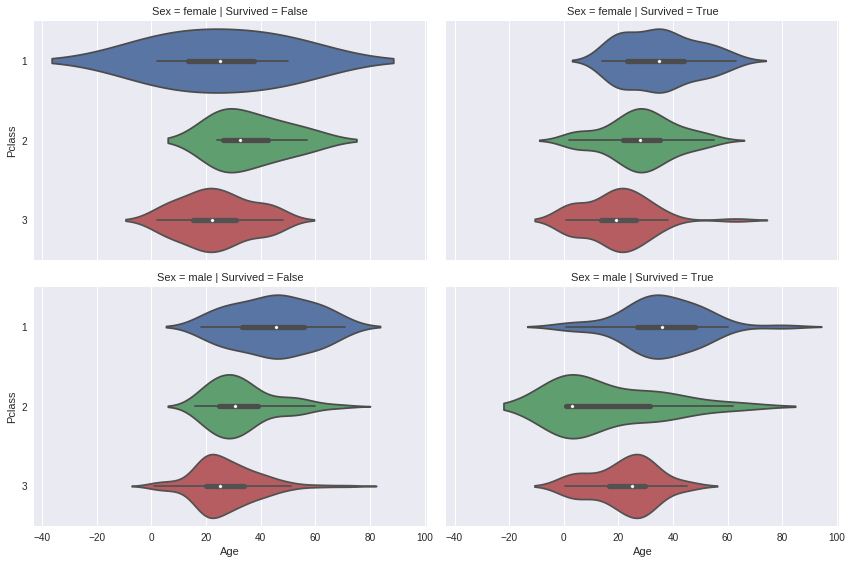

In [65]:
g = sns.FacetGrid(titanic, col='Survived', row='Sex', size=4, aspect=1.5, hue='Pclass')
g.map(sns.violinplot, 'Age', 'Pclass');

One thing that is obvious from the plots is that ticket class seems to be negatively correlated with age (which makes sense, because older people tend to be richer). There are two big effects disturbing the picture: In the group of male passengers who survived (bottom right), the second class consisted of disproportionately many young people, as the median is way in the area considered children. Likelise, the distribution of women who did not survive but inhabited the first class is skewed towards the age of `25`, with a much higher variability.

Since the Titanic rammed the iceberg in the front, where the first class cabins were located, we would have expected to see an effect on all inhabitants of the first class (assuming they were in their cabins). However, the first class cabins were also situated in the higher decks, so access to the lifeboats would have been easier.

Let's take a look at survivorship in relation to the deck the booked cabin was on.

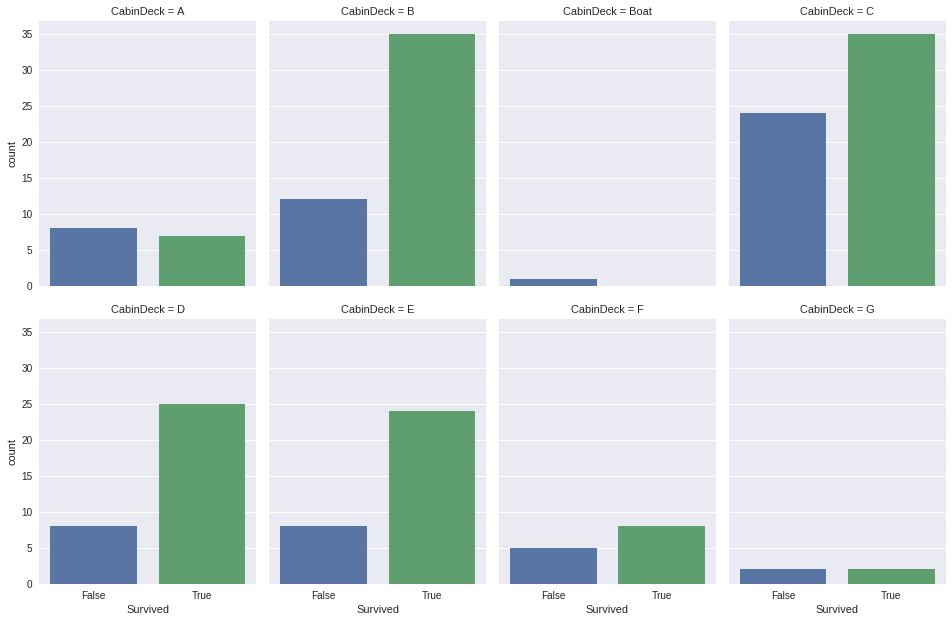

In [66]:
sns.factorplot('Survived', col='CabinDeck', col_wrap=4,
               data=titanic,
               kind='count', size=4.4, aspect=.75);

Interestingly, [Stephen Weart Blackwell](https://www.encyclopedia-titanica.org/titanic-victim/stephen-weart-blackwell.html), who was the only known person in a Boat deck cabin, right next to where the lifeboats were, did not survive the event. Also interestingly, more passengers inhabiting deck A died than those inhabiting the lower decks, except for deck G, where the cabins were located directly next to where the iceberg hit the Titanic.

So did the location of the cabin have an influence?

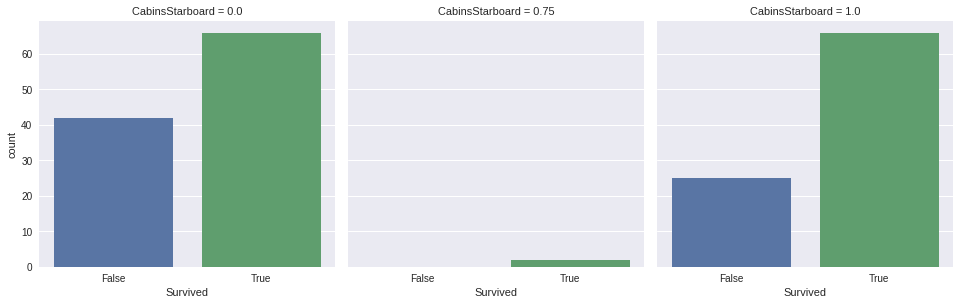

In [67]:
sns.factorplot('Survived', col='CabinsStarboard', col_wrap=4,
               data=titanic,
               kind='count', size=4.4, aspect=1.0);

From this plot it appears that people survived or died no matter the side of the ship their cabin was on. Actually, more people died with cabins on the ship side opposite of the iceberg.

So let's compare the shipdeck to survivorship and sex.

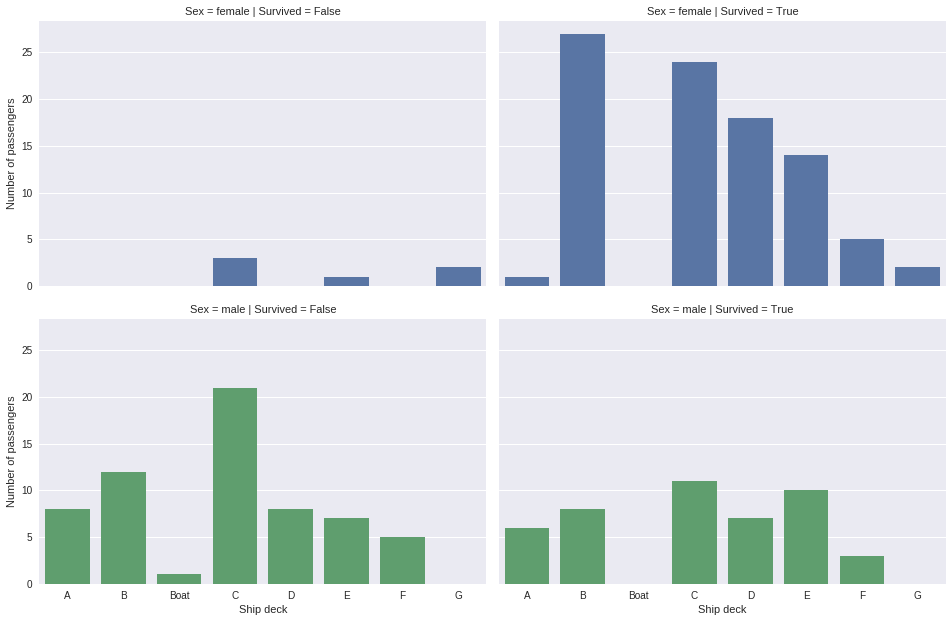

In [68]:
g = sns.FacetGrid(titanic, col='Survived', row='Sex', size=4.4, aspect=1.5, hue='Sex')
g.map(sns.countplot, 'CabinDeck')
g.set_axis_labels("Ship deck", "Number of passengers");

From this it is apparent that the survivorship of men is almost evenly distributed, although more men with cabins in the upper decks seem to have died compared to others. However, the deck does not seem to have an influence on the number of women who survived or died.

## Number of tickets per class and ticket price

Finally, for completeness, let's also have a look at the ticket distribution and their prices.

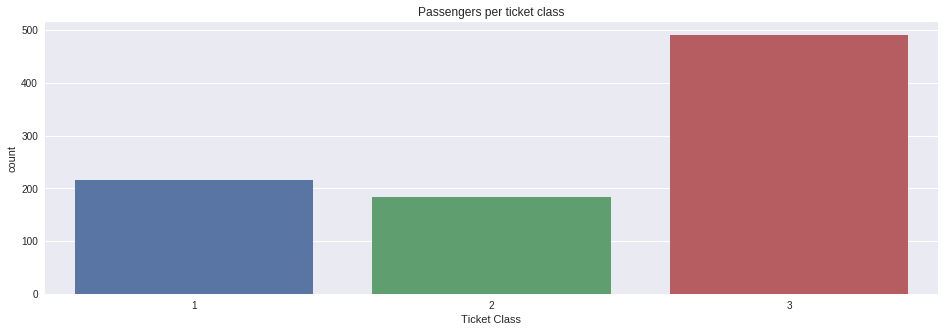

In [69]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.countplot(x='Pclass', data=titanic)
plt.xlabel('Ticket Class')
plt.title('Passengers per ticket class');

Here we can see that about as many 3rd class tickets were sold than there were 1st and 2nd class ones.

So let's look at the price distributions:

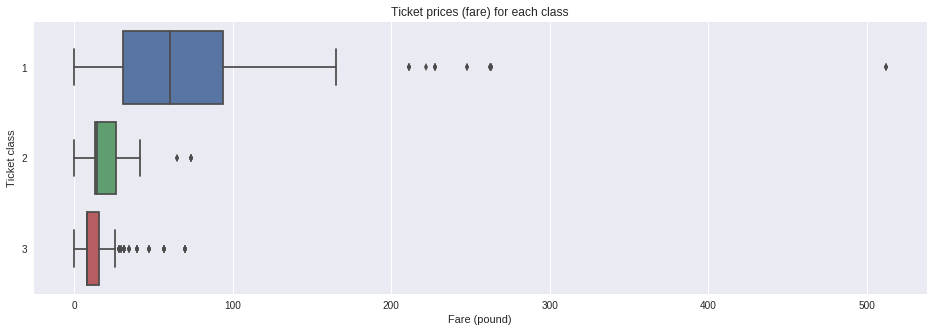

In [70]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.boxplot(x='Fare', data=titanic, y='Pclass')
plt.xlabel('Fare (pound)')
plt.ylabel('Ticket class')
plt.title('Ticket prices (fare) for each class');

There appear to be major outliers in the first class, which we will investigate in a second. It's also interesting to see that some tickets in the third class exceeded the price of regular second class tickets and also lied well withing the IQR of the first class tickets.

In [71]:
titanic[titanic['Fare']  > 400]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix,CabinDeck,NumCabins,CabinsStarboard
PassengerId,,,,,,,,,,,,,,,,,
259,True,1,female,35.0,0,0,512.3292,NaN,C,Ward,Miss. Anna,False,17755,PC,NaN,NaN,NaN
680,True,1,male,36.0,0,1,512.3292,B51 B53 B55,C,Cardeza,Mr. Thomas Drake Martinez,NaN,17755,PC,B,3.0,1
738,True,1,male,35.0,0,0,512.3292,B101,C,Lesurer,Mr. Gustave J,NaN,17755,PC,B,1.0,1


Sadly, none of the owners of the most expensive tickets show any interesting data.

Furthermode, the passengers from the third class who paid well the price for second and first class cabins have very sparse data, so this is a dead end as well.

In [72]:
titanic[(titanic['Fare']  > 50) & (titanic['Pclass'] == 3)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,LastName,FirstName,MarriedWoman,TicketNumber,TicketPrefix,CabinDeck,NumCabins,CabinsStarboard
PassengerId,,,,,,,,,,,,,,,,,
75,True,3,male,32.0,0,0,56.4958,NaN,S,Bing,Mr. Lee,NaN,1601,,NaN,NaN,NaN
160,False,3,male,NaN,8,2,69.5500,NaN,S,Sage,Master. Thomas Henry,NaN,2343,CA.,NaN,NaN,NaN
170,False,3,male,28.0,0,0,56.4958,NaN,S,Ling,Mr. Lee,NaN,1601,,NaN,NaN,NaN
181,False,3,female,NaN,8,2,69.5500,NaN,S,Sage,Miss. Constance Gladys,False,2343,CA.,NaN,NaN,NaN
202,False,3,male,NaN,8,2,69.5500,NaN,S,Sage,Mr. Frederick,NaN,2343,CA.,NaN,NaN,NaN
325,False,3,male,NaN,8,2,69.5500,NaN,S,Sage,Mr. George John Jr,NaN,2343,CA.,NaN,NaN,NaN
510,True,3,male,26.0,0,0,56.4958,NaN,S,Lang,Mr. Fang,NaN,1601,,NaN,NaN,NaN
644,True,3,male,NaN,0,0,56.4958,NaN,S,Foo,Mr. Choong,NaN,1601,,NaN,NaN,NaN
693,True,3,male,NaN,0,0,56.4958,NaN,S,Lam,Mr. Ali,NaN,1601,,NaN,NaN,NaN


# Final words

There is much more to be explored in this dataset, especially when taking into account the actual cabin locations (e.g. by cabin number) to the hull breach, relative numbers of passengers per deck surviving, etc.

As stated initially, the dataset contains information about approximately `40%` of the passengers of the Titanic, and even then, only 83 rows of the entire dataset had all values set. The given information were interpreted as correct and no plausibility checks were performed.

However, the main questions have been answered: The numbers of women and children surviving were significantly higher than the number of men, indeed, and the ticket class had no apparent influence on the survivorship rate.